In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [31]:
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.05, 0.01, 0.01, 0.01),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class SimCLRDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]
        return simclr_transform(img), simclr_transform(img)


In [32]:
base = datasets.CIFAR10(root='./data', train=True, download=True)
from torch.utils.data import Subset
subset = Subset(base, range(2000))  # 2k images for quick experiment
train_data = SimCLRDataset(subset)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)


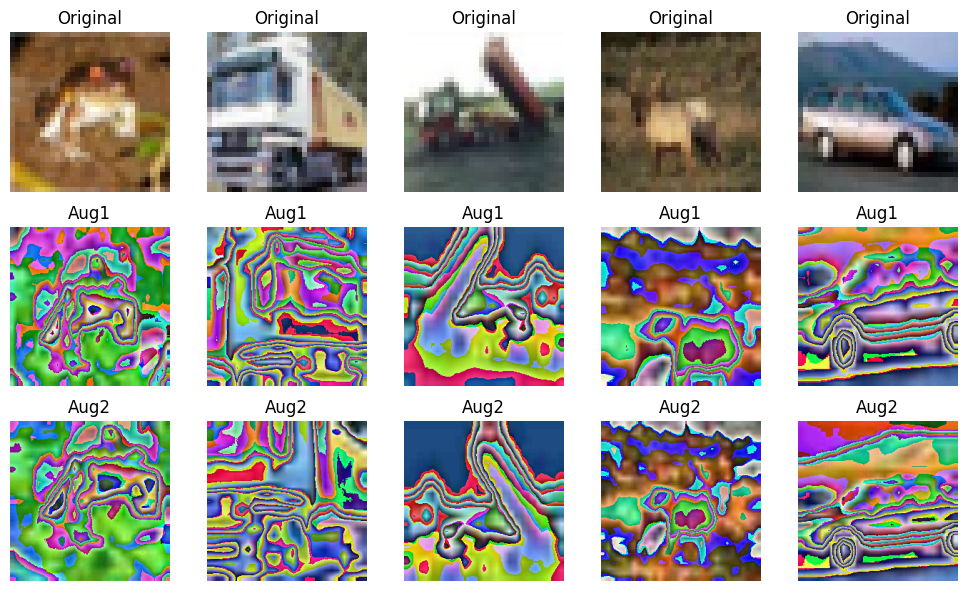

In [33]:
# Viz some augmented images
import matplotlib.pyplot as plt
import torchvision

def show_simclr_triplets(dataset, base_dataset, n=5):
    fig, axes = plt.subplots(3, n, figsize=(2*n, 6))
    to_pil = transforms.ToPILImage()

    for i in range(n):
        orig_img, _ = base_dataset[i]
        aug1, aug2 = dataset[i]

        # Convert to PIL if needed
        def ensure_pil(img):
            return img if isinstance(img, Image.Image) else to_pil(img)

        imgs = [ensure_pil(orig_img), ensure_pil(aug1), ensure_pil(aug2)]
        labels = ["Original", "Aug1", "Aug2"]

        for r in range(3):
            axes[r, i].imshow(imgs[r])
            axes[r, i].set_title(labels[r])
            axes[r, i].axis("off")

    plt.tight_layout()
    plt.show()

show_simclr_triplets(train_data, subset, n=5)


In [34]:
class ViTEncoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3,
                 embed_dim=128, num_heads=4, depth=2):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_embed = nn.Conv2d(in_ch, embed_dim,
                                     kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_dim, num_heads, 4 * embed_dim,
                                       activation='gelu', batch_first=True)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x.mean(dim=1)  # global average pooling


In [35]:
class SimCLRHead(nn.Module):
    def __init__(self, in_dim=128, proj_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, proj_dim)
        )

    def forward(self, x):
        return F.normalize(self.net(x), dim=-1)


In [36]:
class SimCLRModel(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.head = SimCLRHead(encoder.embed_dim)

    def forward(self, x):
        return self.head(self.encoder(x))


In [40]:
def info_nce_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    N = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)                     # [2N, D]
    sim = torch.matmul(z, z.T) / temperature            # [2N, 2N]
    sim.fill_diagonal_(-1e9)                            # mask self-similarity

    # Positive pairs: (i, i+N) and (i+N, i)
    labels = torch.arange(N, device=z.device)
    labels = torch.cat([labels + N, labels], dim=0)     # [2N]

    loss = F.cross_entropy(sim, labels)
    return loss


z1 = torch.randn(64, 128)
z2 = torch.randn(64, 128)
print(info_nce_loss(z1, z2))

tensor(4.8753)


In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = ViTEncoder()
model = SimCLRModel(encoder).to(device)
opt = optim.Adam(model.parameters(), lr=3e-4)

for epoch in range(10):
    model.train()
    total_loss = 0
    for x1, x2 in train_loader:
        x1, x2 = x1.to(device), x2.to(device)
        z1, z2 = model(x1), model(x2)
        loss = info_nce_loss(z1, z2)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * x1.size(0)
    print(f"Epoch {epoch+1}/10 | Loss: {total_loss/len(train_loader.dataset):.4f}")


Epoch 1/10 | Loss: 3.5510
Epoch 2/10 | Loss: 3.4099
Epoch 3/10 | Loss: 3.3881
Epoch 4/10 | Loss: 3.3708
Epoch 5/10 | Loss: 3.3781
Epoch 6/10 | Loss: 3.3499
Epoch 7/10 | Loss: 3.3308
Epoch 8/10 | Loss: 3.3409
Epoch 9/10 | Loss: 3.3275
Epoch 10/10 | Loss: 3.3285
